In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import piqa
import utils
from models import DIP

In [115]:
# img = utils.load_image('data/set5/butterfly.png')
img = utils.load_celeba()
noisy_img = utils.get_noisy_image(img, 0.05)

Files already downloaded and verified


Training on cuda:0
----------
Epoch  100/1800 | Loss: 0.005974440835416317
Epoch  200/1800 | Loss: 0.004803705960512161
Epoch  300/1800 | Loss: 0.004437857307493687
Epoch  400/1800 | Loss: 0.004178323317319155
Epoch  500/1800 | Loss: 0.003723468165844679
Epoch  600/1800 | Loss: 0.0031863178592175245
Epoch  700/1800 | Loss: 0.002944745123386383
Epoch  800/1800 | Loss: 0.0032625130843371153
Epoch  900/1800 | Loss: 0.002900580642744899
Epoch 1000/1800 | Loss: 0.0026657830458134413
Epoch 1100/1800 | Loss: 0.0026457137428224087
Epoch 1200/1800 | Loss: 0.002503711497411132
Epoch 1300/1800 | Loss: 0.0023887897841632366
Epoch 1400/1800 | Loss: 0.002432358916848898
Epoch 1500/1800 | Loss: 0.002251875586807728
Epoch 1600/1800 | Loss: 0.0022230218164622784
Epoch 1700/1800 | Loss: 0.002160961041226983
Epoch 1800/1800 | Loss: 0.0022464185021817684
----------
Finished training in 00:00:50


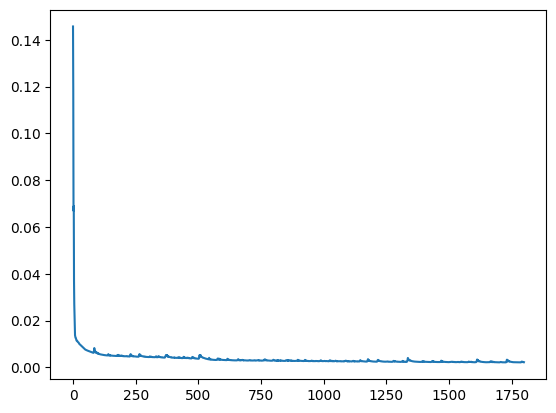

In [116]:
input_channels = 32
deep_channels = [128, 128, 128, 128, 128]
skip_channels = [0, 0, 0, 4, 4]

dip = DIP(input_channels, deep_channels, skip_channels)
denoised_img = dip.denoise(noisy_img)

In [117]:
denoised_img = denoised_img.detach().cpu()
noisy_img = noisy_img.cpu()

In [118]:
psnr = piqa.PSNR()
noisy_psnr = psnr(noisy_img, img).item()
denoised_psnr = psnr(denoised_img, img).item()

print('PSNR (↑)')
print('----------')
print(f'Noisy: {noisy_psnr}')
print(f'Denoised: {denoised_psnr}')

PSNR (↑)
----------
Noisy: 26.872825622558594
Denoised: 33.03471755981445


In [119]:
ssim = piqa.SSIM()
noisy_ssim = ssim(noisy_img, img).item()
denoised_ssim = ssim(denoised_img, img).item()

print('SSIM (↑)')
print('----------')
print(f'Noisy: {noisy_ssim}')
print(f'Denoised: {denoised_ssim}')

SSIM (↑)
----------
Noisy: 0.6141554713249207
Denoised: 0.8801141381263733


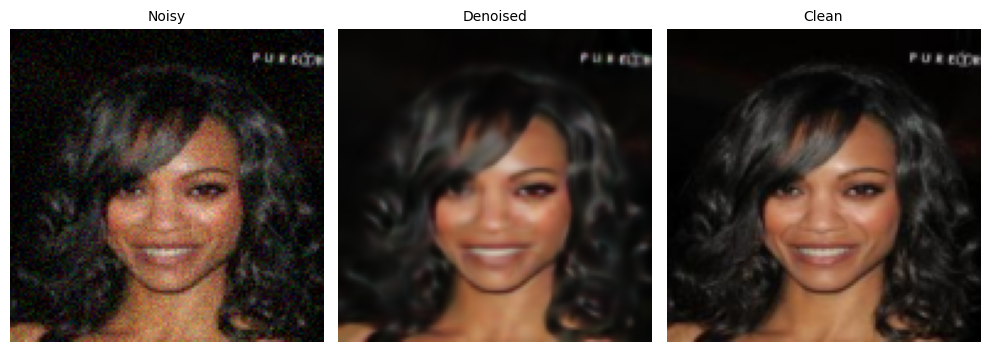

In [120]:
utils.plot_row([noisy_img, denoised_img, img], ['Noisy', 'Denoised', 'Clean'])